In [5]:
import torch
import matplotlib.pyplot as plt
import os
import sys
import warnings
# module_path = os.path.abspath(os.path.join('TF_net'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
from train import Dataset, train_epoch, eval_epoch, test_epoch, Scaler, preprocess
import torch.nn as nn
from torch.utils import data
from scipy import stats
from pathlib import Path
import numpy as np

class Args:
    pass

In [6]:
args = Args() 
args.data = 'data5.pt'


if args.data == "rbc_data.pt":
    compress = True
    permute = False
    offset=0
    transform_type = 'std'
elif args.data == 'data5.pt':
    compress = False
    permute = True
    offset = 60
    transform_type = 'std'
else:
    raise ValueError("Un expected data file name")
args.transform = Scaler(transform_type, offset)


if Path(args.data).name == args.data: args.data = "../" + args.data #============================= extra line ========================================

data_prep = preprocess(args, permute, compress, test_mode=True)

tensor([2.5539e-07])
tensor([0.1367]) <function Scaler.fit_transform.<locals>.<lambda> at 0x7fc2884513a0> <function Scaler.fit_transform.<locals>.<lambda> at 0x7fc2884513a0>


In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def norm_each_sample(x):
    x = torch.clone(x)
    _max= torch.amax(x, dim=(2, 3), keepdim=True) 
    _min= torch.amin(x, dim=(2, 3), keepdim=True) 
    return (x - _min) / (_max - _min)

def plot(video, channel, start=0, frames = None):
    if frames is None:
        frames = video.shape[0]
    warnings.warn("Going to normalize each sample for visualizing purpose")
    video = norm_each_sample(video)
    fig = plt.figure()
    im = plt.imshow(video[start,channel,:,:])

    plt.close() # this is required to not display the generated image

    def init():
        im.set_data(video[start,channel,:,:])

    def animate(i):
        im.set_data(video[start+i,channel,:,:])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames,
                                interval=50)    #20 fps
    return anim.to_html5_video()

# HTML(plot(data_prep, 0, 1100, 120))

In [9]:
test_indices = list(range(7700, 9800))
input_length = 26
time_range = 6
batch_size = 21
device = "cuda:"
device_ids = [1]
args.path = "../results/tfnet_data5_offset--dnsn_noise_4_wt_d_1e-5_enc_3/tfnet_data5_offset--dnsn_noise_4_wt_d_1e-5_enc_3_17/"
kernel_size=3
dropout_rate=0

device = torch.device(f"cuda:{device_ids[0]}" if torch.cuda.is_available() else "cpu")
loss_fun = torch.nn.MSELoss()

best_model = nn.DataParallel(torch.load(args.path+"model.pth", map_location=device).module, device_ids=device_ids)
data_prep = preprocess(args, permute, compress, test_mode=True)

print("Testing in test setting")
test_set = Dataset(test_indices, input_length + time_range - 1, 40, 60, data_prep, True,test_mode=True)
test_loader = data.DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = 8)
preds, trues, loss_curve = test_epoch(args, test_loader, best_model, loss_fun, test_mode=True, save_preds= True, device=device)

torch.save({"loss_curve": loss_curve}, 
            args.path+"results.pt",pickle_protocol=5)

tensor([2.5539e-07])
tensor([0.1367]) <function Scaler.fit_transform.<locals>.<lambda> at 0x7fc28846d790> <function Scaler.fit_transform.<locals>.<lambda> at 0x7fc28846d790>
Testing in test setting


100%|██████████| 100/100 [06:04<00:00,  3.64s/it]


[0.00218017 0.00285634 0.00368138 0.0047266  0.00593224 0.00718091
 0.00854396 0.00995863 0.01148602 0.01299091 0.0145815  0.01624368
 0.01787469 0.01951457 0.021261   0.02293178 0.02463396 0.02637973
 0.02815068 0.02992184 0.03168209 0.03345274 0.03526622 0.03702444
 0.03882464 0.0406039  0.04237817 0.04413846 0.04589126 0.0476183
 0.04932478 0.05100224 0.05265737 0.05427588 0.05585922 0.05741262
 0.05893336 0.06040899 0.06185406 0.06325932 0.06462895 0.06596027
 0.06725582 0.06851473 0.06973945 0.07092565 0.07208064 0.07319739
 0.07427968 0.07532716 0.07634038 0.07731692 0.07826125 0.07917206
 0.08005236 0.08090219 0.08172456 0.08252114 0.08329407 0.08404507]


In [12]:
ndx = 52
ones = 0.1*np.ones_like(preds[ndx])
obs = np.concatenate((preds[ndx], ones, trues[ndx]),axis=2)
HTML(plot(torch.from_numpy(obs), 0))

In [17]:
HTML(plot(torch.from_numpy(preds[ndx]), 0))

In [21]:
print(stats.describe(preds, None))
print(stats.describe(trues, None))

(array([[ 0.,  0.,  7., ...,  0.,  0.,  0.],
        [ 0.,  0.,  7., ...,  0.,  0.,  0.],
        [ 0.,  0.,  7., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  9., 10., 11.],
        [ 0.,  0.,  0., ...,  9., 10., 11.],
        [ 0.,  0.,  0., ..., 10., 10., 11.]]),
 array([0.30961025, 0.30964309, 0.30967593, 0.3097088 , 0.30974165,
        0.30977449, 0.30980733, 0.30984017, 0.30987304, 0.30990589,
        0.30993873]),
 <a list of 448 BarContainer objects>)

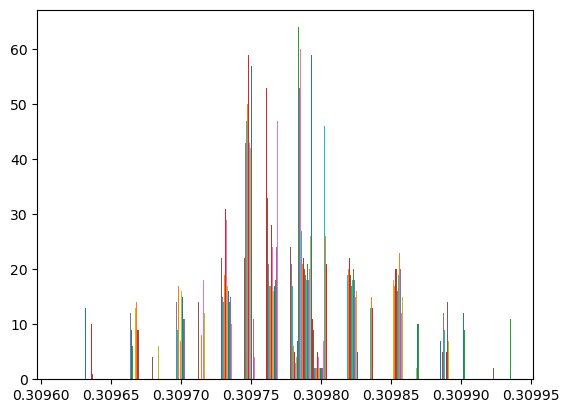

In [19]:
plt.hist(trues[ndx,0,0])

In [ ]:
! We loose details over long horizon.